# FIT5212: Data analysis for semi-structured data

## Assignment 1

**Student Name:** Udit Arora

**Student Id:** 31167799

### Special libraries used for this assignment:

Uncomment these commands if installation is required.

In [1]:
#!pip install pyLDAvis
#!pip install gensim
#!pip install torch
#!pip3 install torchtext
#!pip install nltk
#!pip install spacy

## Part 1: Text Classification

The goal of this task is to create text classifiers that predict each of the three classes namely 'InfoTheory', 'CompVis' and 'Math' individually using the Abstract field. Certain sets of pre-processing tasks are needed to performed before classification.

## Neural network model

### Common code:

In [2]:
# COMMON CODE
#Load the data files
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

train_df = pd.read_csv("axcs_train.csv")
test_df = pd.read_csv("axcs_test.csv")

#stop words and punctuations list
stop_words_and_punctuations = list(string.punctuation) + list(" ") + list(stopwords.words('english'))

    
# Libraries for neural network
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset
import torch.nn as nn
import torch.optim as optim


seed = 1234

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#Preprocessing functions
#For Label preprocessing
def pre_process(x):
        if(len(x)==0):
            return 0
        else:
            return x
        
#For text preprocessing
def pre_processing_text(x):
        if(len(x)==0):
            return 'NA'
        else:
            return x

#LABEL and TEXT on every row in the dataframe

LABEL = data.LabelField(dtype = torch.float, 
                        use_vocab=False, preprocessing=pre_process)

TEXT = data.Field(sequential=True, stop_words=stop_words_and_punctuations, 
                  tokenize = 'spacy', lower=True, preprocessing=pre_processing_text)

MAX_VOCAB_SIZE = 5000


class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))


def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/uditarora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uditarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/uditarora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/uditarora/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


### Code for 'InfoTheory':

In [3]:
#infoTheory dataset
#Passing 'None' in the field which are of no use
d_fields_infotheory = [("ID", None), ("URL",None), ('Date',None),
            ('Title',None), ('InfoTheory',LABEL), ('CompVis',None),
                 ('Math',None), ("Abstract", TEXT)]

train_infotheory = TabularDataset(
    path = 'axcs_train.csv',
    format='csv',
    skip_header=True,
    fields=d_fields_infotheory)

test_infotheory = TabularDataset(
    path = 'axcs_test.csv',
    format='csv',
    skip_header=True,
    fields=d_fields_infotheory)

#Info theory vocabulary
TEXT.build_vocab(train_infotheory, max_size = MAX_VOCAB_SIZE)

BATCH_SIZE = 16

#Info theory iterator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_infotheory_itr = data.BucketIterator(
    train_infotheory, 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

test_infotheory_itr = data.BucketIterator(
    test_infotheory, 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

#Info theory batch
batch = next(train_infotheory_itr.__iter__())

#model for Info theory
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

#RNN function
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 592,105 trainable parameters


In [4]:
#Training the model

import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

def train_infotheory(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Abstract).squeeze(1)
        
        loss = criterion(predictions, batch.InfoTheory)
        
        acc = binary_accuracy(predictions, batch.InfoTheory)
        
        loss.backward()
        
        optimizer.step()


        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

infotheory_train_loss, infotheory_train_acc = train_infotheory(model, train_infotheory_itr, optimizer, criterion)

#On test data

y_predict_infotheory = []
y_test_infotheory = []

with torch.no_grad():
    for batch in test_infotheory_itr:
        predictions = model(batch.Abstract).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict_infotheory += rounded_preds.tolist()
        y_test_infotheory += batch.InfoTheory.tolist()
        
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np

#confusion matrix
y_predict_infotheory = np.asarray(y_predict_infotheory)
y_test_infotheory = np.asarray(y_test_infotheory)
print('InfoTheory')
print(confusion_matrix(y_test_infotheory,y_predict_infotheory))
recall=recall_score(y_test_infotheory,y_predict_infotheory,average='macro')
precision=precision_score(y_test_infotheory,y_predict_infotheory,average='macro')
f1score=f1_score(y_test_infotheory,y_predict_infotheory,average='macro')
accuracy=accuracy_score(y_test_infotheory,y_predict_infotheory)
matthews = matthews_corrcoef(y_test_infotheory,y_predict_infotheory) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

InfoTheory
[[15854   208]
 [ 3558    58]]
Accuracy: 0.8086187620693159
Macro Precision: 0.5173782126860527
Macro Recall: 0.5015450017796085
Macro F1 score:0.4618596223480189
MCC:0.010363275452551737


### Code for 'CompVis':

In [5]:
#compvis dataset
#Passing 'None' in the field which are of no use

d_fields_compvis = [("ID", None), ("URL",None),('Date',None),
                ('Title',None), ('InfoTheory',None), ('CompVis',LABEL),
                 ('Math',None), ("Abstract", TEXT)]

train_compvis = TabularDataset(
    path='axcs_train.csv',
    format='csv',
    skip_header=True,
    fields=d_fields_compvis)

test_compvis = TabularDataset(
    path='axcs_test.csv',
    format='csv',
    skip_header=True,
    fields=d_fields_compvis)

#Info Theory Vocabulory
TEXT.build_vocab(train_compvis, max_size = MAX_VOCAB_SIZE)

BATCH_SIZE = 16

#compvis iterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_compvis_itr = data.BucketIterator(
    train_compvis, 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

test_compvis_itr = data.BucketIterator(
    test_compvis, 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

#compvis batch
batch = next(train_compvis_itr.__iter__())

#compvis model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 592,105 trainable parameters


In [6]:
#Training the model
optimizer = optim.SGD(model.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

def train_compvis(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Abstract).squeeze(1)
        
        loss = criterion(predictions, batch.CompVis)
        
        acc = binary_accuracy(predictions, batch.CompVis)
        
        loss.backward()
        
        optimizer.step()


        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

compvis_train_loss, compvis_train_acc = train_compvis(model, train_compvis_itr, optimizer, criterion)

#On test data

y_predict_compvis = []
y_test_compvis = []

with torch.no_grad():
    for batch in test_compvis_itr:
        predictions = model(batch.Abstract).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict_compvis += rounded_preds.tolist()
        y_test_compvis += batch.CompVis.tolist()
        
#confusion matrix

y_predict_compvis = np.asarray(y_predict_compvis)
y_test_compvis = np.asarray(y_test_compvis)
print('CompVis')
print(confusion_matrix(y_test_compvis,y_predict_compvis))
recall=recall_score(y_test_compvis,y_predict_compvis,average='macro')
precision=precision_score(y_test_compvis,y_predict_compvis,average='macro')
f1score=f1_score(y_test_compvis,y_predict_compvis,average='macro')
accuracy=accuracy_score(y_test_compvis,y_predict_compvis)
matthews = matthews_corrcoef(y_test_compvis,y_predict_compvis) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

CompVis
[[17471    55]
 [ 2147     5]]
Accuracy: 0.888098383982112
Macro Precision: 0.4869465117069358
Macro Recall: 0.4995926126960815
Macro F1 score:0.4726190021806534
MCC:-0.004612082133892794


### Code for 'Math':

In [7]:
#math dataset
#Passing 'None' in the field which are of no use

d_fields_math = [("ID", None), ("URL",None), ('Date',None),
                ('Title',None), ('InfoTheory',None),('CompVis',None),
                 ('Math',LABEL), ("Abstract", TEXT)]

train_math = TabularDataset(
    path='axcs_train.csv',
    format='csv',
    skip_header=True,
    fields=d_fields_math)

test_math = TabularDataset(
    path='axcs_test.csv',
    format='csv',
    skip_header=True,
    fields=d_fields_math)

#Info Theory Vocabulory
TEXT.build_vocab(train_math, max_size = MAX_VOCAB_SIZE)

BATCH_SIZE = 16

#math iterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_math_itr = data.BucketIterator(
    train_math, 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

test_math_itr = data.BucketIterator(
    test_math, 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

#math batch
batch = next(train_math_itr.__iter__())

#math model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 592,105 trainable parameters


In [8]:
#Training the model

optimizer = optim.SGD(model.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

def train_Math(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Abstract).squeeze(1)
        
        loss = criterion(predictions, batch.Math)
        
        acc = binary_accuracy(predictions, batch.Math)
        
        loss.backward()
        
        optimizer.step()


        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

math_train_loss, math_train_acc = train_Math(model, test_math_itr, optimizer, criterion)

#On test data

y_predict_math = []
y_test_math = []

with torch.no_grad():
    for batch in test_math_itr:
        predictions = model(batch.Abstract).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict_math += rounded_preds.tolist()
        y_test_math += batch.Math.tolist()
        
y_predict_math = np.asarray(y_predict_math)
y_test_math = np.asarray(y_test_math)
print('Math')
print(confusion_matrix(y_test_math,y_predict_math))
recall=recall_score(y_test_math,y_predict_math,average='macro')
precision=precision_score(y_test_math,y_predict_math,average='macro')
f1score=f1_score(y_test_math,y_predict_math,average='macro')
accuracy=accuracy_score(y_test_math,y_predict_math)
matthews = matthews_corrcoef(y_test_math,y_predict_math) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

Math
[[13549   199]
 [ 5831    99]]
Accuracy: 0.6935664193515602
Macro Precision: 0.5156687860591075
Macro Recall: 0.5011099698205375
Macro F1 score:0.4248853283044362
MCC:0.00834071451377329


## Machine learning models

In this section, we compare different machine learning models 'LogisticRegression', 'BernoulliNB', 'LinearSVC' and 'RandomForestClassifier' on the basis of their performance on training data and select the best performing model from this analysis and analyse the performance of that model on the test data.

### Pre-processing the training data and common code:

In [9]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef

train_ml = train_df[['InfoTheory','CompVis','Math','Abstract']]

train_ml_Abstract = train_ml.Abstract.tolist()
train_ml_InfoTheory = train_ml.InfoTheory.tolist() 
train_ml_CompVis = train_ml.CompVis.tolist() 
train_ml_Math = train_ml.Math.tolist() 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in RegexpTokenizer('[a-zA-Z]+').tokenize(doc)]
    
vectorizer=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           min_df=5,
                            max_df=0.8,
                           stop_words=stop_words_and_punctuations,
                           tokenizer=LemmaTokenizer())

#Models 
models = [
   LogisticRegression(),
   BernoulliNB(),
    LinearSVC(),
    RandomForestClassifier()
]

#Labels
x_train_Abstract=vectorizer.fit_transform(train_ml_Abstract)
y_train_InfoTheory=np.asarray(train_ml_InfoTheory)
y_train_CompVis=np.asarray(train_ml_CompVis)
y_train_Math=np.asarray(train_ml_Math)


CV = 7 #Number of folds for cross validation

#Cross-fold validation on different ML models

def cv_ml_models(x_train, y_train):
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
         model_name = model.__class__.__name__
         accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
         for fold_idx, accuracy in enumerate(accuracies):
              entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    return cv_df


/Users/uditarora/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


### Performace of models on training data for 'InfoTheory'

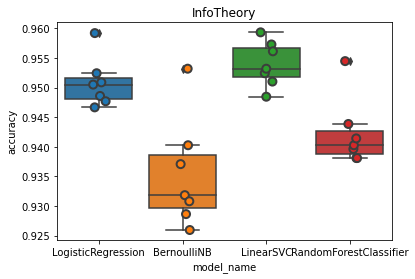

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

cv_df_infotheory = cv_ml_models(x_train_Abstract, y_train_InfoTheory)

sns.boxplot(x='model_name', y='accuracy', data=cv_df_infotheory).set_title('InfoTheory')
sns.stripplot(x='model_name', y='accuracy', data=cv_df_infotheory, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### Performance of models on training data for 'CompVis'

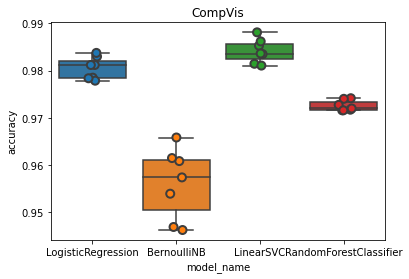

In [11]:
cv_df_compvis = cv_ml_models(x_train_Abstract, y_train_CompVis)

sns.boxplot(x='model_name', y='accuracy', data=cv_df_compvis).set_title('CompVis')
sns.stripplot(x='model_name', y='accuracy', data=cv_df_compvis, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### Performance of models on training data for 'Math'

/Users/uditarora/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/uditarora/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

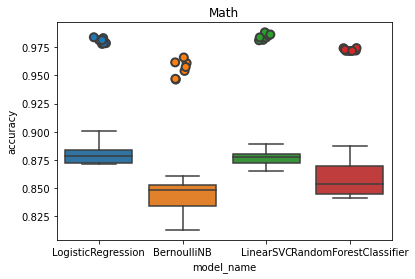

In [12]:
cv_df_math = cv_ml_models(x_train_Abstract, y_train_Math)

sns.boxplot(x='model_name', y='accuracy', data=cv_df_math).set_title('Math')
sns.stripplot(x='model_name', y='accuracy', data=cv_df_compvis, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### Model selection:

Analysing the performances of different models for the three variables, we can see that the model 'Linear SVC' has the maximum accuracy rates for all the three variables as compared to other models as shown in the plots above. 

Let's see how this model performs on the test data.

#### Performance of 'Linear SVC' on test data:

##### Test data preparation - 

In [13]:
lsvc_test_df = test_df[['InfoTheory','CompVis','Math','Abstract']]

lsvc_test_df_1 = lsvc_test_df.dropna()

#labels

test_lsvc_Abstract = lsvc_test_df_1.Abstract.tolist()
test_lsvc_InfoTheory = lsvc_test_df_1.InfoTheory.tolist() 
test_lsvc_CompVis = lsvc_test_df_1.CompVis.tolist() 
test_lsvc_Math = lsvc_test_df_1.Math.tolist() 

#Vectorizing
x_test_abstract=vectorizer.transform(test_lsvc_Abstract)
y_test_infotheory=np.asarray(test_lsvc_InfoTheory)
y_test_compvis=np.asarray(test_lsvc_CompVis)
y_test_math=np.asarray(test_lsvc_Math)

#### Linear SVC model on 'InfoTheory', 'CompVis' and 'Math' -

In [14]:
#for 'Infotheory'
model = LinearSVC()
model_name = model.__class__.__name__
model.fit(x_train_Abstract, y_train_InfoTheory)
print(model_name + " for InfoTheory")
y_predict=model.predict(x_test_abstract)
print(confusion_matrix(y_test_infotheory,y_predict))
recall=recall_score(y_test_infotheory,y_predict,average='macro')
precision=precision_score(y_test_infotheory,y_predict,average='macro')
f1score=f1_score(y_test_infotheory,y_predict,average='macro')
accuracy=accuracy_score(y_test_infotheory,y_predict)
matthews = matthews_corrcoef(y_test_infotheory,y_predict) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

LinearSVC for InfoTheory
[[15779   283]
 [  664  2952]]
Accuracy: 0.9518751905681472
Macro Precision: 0.9360686972493897
Macro Recall: 0.8993762279573732
Macro F1 score:0.9163190123496041
MCC:0.8346387756095376


In [15]:
#for 'CompVis'
model = LinearSVC()
model_name = model.__class__.__name__
model.fit(x_train_Abstract, y_train_CompVis)
print(model_name+" for CompVis")
y_predict=model.predict(x_test_abstract)
print(confusion_matrix(y_test_compvis,y_predict))
recall=recall_score(y_test_compvis,y_predict,average='macro')
precision=precision_score(y_test_compvis,y_predict,average='macro')
f1score=f1_score(y_test_compvis,y_predict,average='macro')
accuracy=accuracy_score(y_test_compvis,y_predict)
matthews = matthews_corrcoef(y_test_compvis,y_predict) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

LinearSVC for CompVis
[[17426   100]
 [  506  1646]]
Accuracy: 0.9692041874174204
Macro Precision: 0.9572542600160105
Macro Recall: 0.8795820399813851
Macro F1 score:0.9137225084311226
MCC:0.8332238710144015


In [16]:
#for 'Math'
model = LinearSVC()
model_name = model.__class__.__name__
model.fit(x_train_Abstract, y_train_Math)
print(model_name+" for Math")
y_predict=model.predict(x_test_abstract)
print(confusion_matrix(y_test_math,y_predict))
recall=recall_score(y_test_math,y_predict,average='macro')
precision=precision_score(y_test_math,y_predict,average='macro')
f1score=f1_score(y_test_math,y_predict,average='macro')
accuracy=accuracy_score(y_test_math,y_predict)
matthews = matthews_corrcoef(y_test_math,y_predict) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

LinearSVC for Math
[[12710  1038]
 [ 1507  4423]]
Accuracy: 0.8706677507876817
Macro Precision: 0.8519625314260402
Macro Recall: 0.8351832871229223
Macro F1 score:0.8427856923817274
MCC:0.6869409238864286


## Results

### For Neural Network Method:


Confusion matrix for **'InfoTheory'**:

|              | **Pred=True** | **Pred=False** |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 15838       |   224  |
| **Actual=False** | 3554        |   62 |

Confusion matrix for **'CompVis'**:

|              | **Pred=True** | **Pred=False** |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 17409       |   117  |
| **Actual=False** | 2138        |   14 |

Confusion matrix for **'Math'**:

|              | **Pred=True** | **Pred=False** |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 13639       |   109  |
| **Actual=False** | 5862        |   69 |


### For Machine Learning Model (Linear SVC): 

Confusion matrix for **'InfoTheory'**:

|              | **Pred=True** | **Pred=False** |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 15779       |   283  |
| **Actual=False** | 664        |   2952 |

Confusion matrix for **'CompVis'**:

|              | **Pred=True** | **Pred=False** |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 17426       |   100  |
| **Actual=False** | 506        |   1646 |

Confusion matrix for **'Math'**:

|              | **Pred=True** | **Pred=False** |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 12710       |   1038  |
| **Actual=False** | 1506        |   4424 |


## Part 2: Topic Modelling

Topic modelling is a statistical model for discovering abstract 'topics' that occur in a collection of documents.

We will be creating two different models for topic modelling. For the first model we will be using bigrams and number of topics = 10, and for the second model we will not be using bigrams and number of topics = 40 for this model. We will be comparing these two models on the first 1000 and the first 20,000 articles in the training data set.

### Common code:

In [9]:
#function to create tokens
def read_data_create_tokens_lemm(size_of_data):
    #input data
    train_df = pd.read_csv("axcs_train.csv")
    train_df = train_df[0:size_of_data]
    #list for text pre-processing
    docs = train_df['Abstract'].tolist()

    # creating tokens
    text_tokenizer = RegexpTokenizer(r'\w+')
    for i in range(len(docs)):
        docs[i] = docs[i].lower() #convert to lowercase
        docs[i] = text_tokenizer.tokenize(docs[i]) #split into words
    
    # Remove only numbers
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]

    #lemmatizing the text from the input abstract data
    text_lemmatizer = WordNetLemmatizer()
    docs = [[text_lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    return (docs)

## For model 1: 

This model is created using bigrams and number of topics = 10.

**For first 1000 articles in the training data:**

In [10]:
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from gensim.models import LdaModel


#For first 1000 articles in the training data

#get tokens
docs_model_1_1000 = read_data_create_tokens_lemm(1000)

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs_model_1_1000, min_count=20)
for i in range(len(docs_model_1_1000)):
    for token in bigram[docs_model_1_1000[i]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs_model_1_1000[i].append(token)
            
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs_model_1_1000)

# Remove rare and common tokens.
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus_model_1_1000 = [dictionary.doc2bow(doc) for doc in docs_model_1_1000]

# Train LDA model.

# Set training parameters.
NUM_TOPICS = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity

# Make a index to word dictionary.
temp = dictionary[0]  # Thise is only to "load" the dictionary.
id2word = dictionary.id2token

model_1_1000 = LdaModel(
    corpus=corpus_model_1_1000,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model_1_1000{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model_1_1000.save(outputfile)

top_topics = model_1_1000.top_topics(corpus_model_1_1000) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_display = gensimvis.prepare(model_1_1000, corpus_model_1_1000, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)


Saving model in model_1_100010.gensim

Average topic coherence: -1.6175.


**For first 20,000 articles in the training data:**

In [11]:
from gensim.models import LdaModel

#For first 20000 articles in the training data

#get tokens
docs_model_1_20000 = read_data_create_tokens_lemm(20000)

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs_model_1_20000, min_count=20)
for i in range(len(docs_model_1_20000)):
    for token in bigram[docs_model_1_20000[i]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs_model_1_20000[i].append(token)
            
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs_model_1_20000)

# Remove rare and common tokens.
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus_model_1_20000 = [dictionary.doc2bow(doc) for doc in docs_model_1_20000]

# Train LDA model.

# Set training parameters.
NUM_TOPICS = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model_1_20000 = LdaModel(
    corpus=corpus_model_1_20000,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model_1_20000{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model_1_20000.save(outputfile)

top_topics = model_1_20000.top_topics(corpus_model_1_20000) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_display = gensimvis.prepare(model_1_20000, corpus_model_1_20000, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

Saving model in model_1_2000010.gensim

Average topic coherence: -1.9204.


## For model 2: 

This model is created without using bigrams and number of topics = 40.

**For first 1000 articles in the training data:**

In [12]:
from gensim.models import LdaModel

#For first 1000 articles in the training data

#get tokens
docs_model_2_1000 = read_data_create_tokens_lemm(1000)
            
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs_model_2_1000)

# Remove rare and common tokens.
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus_model_2_1000 = [dictionary.doc2bow(doc) for doc in docs_model_2_1000]

# Train LDA model.

# Set training parameters.
NUM_TOPICS = 40
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity

# Make a index to word dictionary.
temp = dictionary[0]  # Thise is only to "load" the dictionary.
id2word = dictionary.id2token

model_2_1000 = LdaModel(
    corpus=corpus_model_2_1000,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model_2_1000{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model_2_1000.save(outputfile)

top_topics = model_2_1000.top_topics(corpus_model_2_1000) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_display = gensimvis.prepare(model_2_1000, corpus_model_2_1000, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

Saving model in model_2_100040.gensim

Average topic coherence: -2.0099.


**For the first 20,000 articles in the training data:**

In [13]:
from gensim.models import LdaModel
import scipy
scipy.test()
#For first 1000 articles in the training data

#get tokens
docs_model_2_20000 = read_data_create_tokens_lemm(20000)
            
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs_model_2_20000)

# Remove rare and common tokens.
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus_model_2_20000 = [dictionary.doc2bow(doc) for doc in docs_model_2_20000]

# Train LDA model.

# Set training parameters.
NUM_TOPICS = 40
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity

# Make a index to word dictionary.
temp = dictionary[0]  # Thise is only to "load" the dictionary.
id2word = dictionary.id2token

model_2_20000 = LdaModel(
    corpus=corpus_model_2_20000,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model_2_20000{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model_2_20000.save(outputfile)

top_topics = model_2_20000.top_topics(corpus_model_2_20000)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_display = gensimvis.prepare(model_2_20000, corpus_model_2_20000, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

Saving model in model_2_2000040.gensim

Average topic coherence: -4.5320.


## Dominant topics and their corresponding documents

In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus_model_2_1000, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

**For Model 1:**

In [16]:
#For model 'model_1_1000'

df_topic_sents_keywords = format_topics_sentences(ldamodel=model_1_1000, corpus=corpus_model_1_1000, texts=docs_model_1_1000)

# Format
df_dominant_topic1 = df_topic_sents_keywords.reset_index()
df_dominant_topic1.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic1.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.5337,"be, can, by, can_be, theory, a, it, which, tre...","[nested, satisfiability, special, case, of, th..."
1,1,4.0,0.9350,"algorithm, context, time, state, by, be, probl...","[note, on, digitized, angle, we, study, the, c..."
2,2,6.0,0.9665,"discourse, model, translation, it, sentence, w...","[textbook, example, of, recursion, we, discus,..."
3,3,3.0,0.7505,"be, can, by, can_be, theory, a, it, which, tre...","[theory, and, practice, the, author, argues, t..."
4,4,3.0,0.7654,"be, can, by, can_be, theory, a, it, which, tre...","[context, free, multilanguages, this, article,..."
5,5,3.0,0.9212,"be, can, by, can_be, theory, a, it, which, tre...","[the, problem, of, compatible, representative,..."
6,6,2.0,0.4585,"it, be, system, language, domain, model, can, ...","[market, oriented, programming, environment, a..."
7,7,3.0,0.5085,"be, can, by, can_be, theory, a, it, which, tre...","[dynamic, backtracking, because, of, their, oc..."
8,8,4.0,0.9951,"algorithm, context, time, state, by, be, probl...","[an, empirical, analysis, of, search, in, gsat..."
9,9,3.0,0.9861,"be, can, by, can_be, theory, a, it, which, tre...","[linear, construction, for, certain, kerdock, ..."


In [17]:
#For model 'model_1_20000'

df_topic_sents_keywords = format_topics_sentences(ldamodel=model_1_20000, corpus=corpus_model_1_20000, texts=docs_model_1_20000)

# Format
df_dominant_topic2 = df_topic_sents_keywords.reset_index()
df_dominant_topic2.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic2.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7226,"a, be, model, which, it, can, system, problem,...","[nested, satisfiability, special, case, of, th..."
1,1,8.0,0.6705,"algorithm, problem, graph, time, network, numb...","[note, on, digitized, angle, we, study, the, c..."
2,2,1.0,0.8166,"a, be, model, which, it, can, system, problem,...","[textbook, example, of, recursion, we, discus,..."
3,3,5.0,0.4982,"system, a, data, it, be, application, paper, u...","[theory, and, practice, the, author, argues, t..."
4,4,1.0,0.4841,"a, be, model, which, it, can, system, problem,...","[context, free, multilanguages, this, article,..."
5,5,1.0,0.6879,"a, be, model, which, it, can, system, problem,...","[the, problem, of, compatible, representative,..."
6,6,1.0,0.3849,"a, be, model, which, it, can, system, problem,...","[market, oriented, programming, environment, a..."
7,7,1.0,0.3886,"a, be, model, which, it, can, system, problem,...","[dynamic, backtracking, because, of, their, oc..."
8,8,1.0,0.3499,"a, be, model, which, it, can, system, problem,...","[an, empirical, analysis, of, search, in, gsat..."
9,9,7.0,0.4540,"code, matrix, linear, algorithm, error, decodi...","[linear, construction, for, certain, kerdock, ..."


**For Model 2:**

In [18]:
#For model 'model_2_1000'

df_topic_sents_keywords = format_topics_sentences(ldamodel=model_2_1000, corpus=corpus_model_2_1000, texts=docs_model_2_1000)

# Format
df_dominant_topic3 = df_topic_sents_keywords.reset_index()
df_dominant_topic3.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic3.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,39.0,0.9559,"grammar, tree, dependency, head, adjoining, le...","[nested, satisfiability, special, case, of, th..."
1,1,14.0,0.8908,"model, two, language, modeling, level, paramet...","[note, on, digitized, angle, we, study, the, c..."
2,2,1.0,0.5466,"translation, sentence, english, machine, japan...","[textbook, example, of, recursion, we, discus,..."
3,3,36.0,0.5714,"language, system, be, knowledge, it, can, natu...","[theory, and, practice, the, author, argues, t..."
4,4,7.0,0.5081,"language, database, natural, constraint, inter...","[context, free, multilanguages, this, article,..."
5,5,35.0,0.5125,"word, be, agent, can, method, which, sense, a,...","[the, problem, of, compatible, representative,..."
6,6,35.0,0.4976,"word, be, agent, can, method, which, sense, a,...","[market, oriented, programming, environment, a..."
7,7,39.0,0.5441,"grammar, tree, dependency, head, adjoining, le...","[dynamic, backtracking, because, of, their, oc..."
8,8,12.0,0.5688,"algorithm, model, set, based, it, problem, app...","[an, empirical, analysis, of, search, in, gsat..."
9,9,3.0,0.6342,"language, by, be, a, it, semantics, can, repre...","[linear, construction, for, certain, kerdock, ..."


In [19]:
#For model 'model_2_20000'

df_topic_sents_keywords = format_topics_sentences(ldamodel=model_2_20000, corpus=corpus_model_2_20000, texts=docs_model_2_20000)

# Format
df_dominant_topic4 = df_topic_sents_keywords.reset_index()
df_dominant_topic4.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic4.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,21.0,0.2612,"be, can, it, which, set, a, show, one, number,...","[nested, satisfiability, special, case, of, th..."
1,1,21.0,0.3346,"be, can, it, which, set, a, show, one, number,...","[note, on, digitized, angle, we, study, the, c..."
2,2,21.0,0.2368,"be, can, it, which, set, a, show, one, number,...","[textbook, example, of, recursion, we, discus,..."
3,3,25.0,0.4130,"a, it, be, have, information, ha, from, paper,...","[theory, and, practice, the, author, argues, t..."
4,4,25.0,0.3402,"a, it, be, have, information, ha, from, paper,...","[context, free, multilanguages, this, article,..."
5,5,21.0,0.3585,"be, can, it, which, set, a, show, one, number,...","[the, problem, of, compatible, representative,..."
6,6,36.0,0.2380,"service, resource, distributed, scheduling, gr...","[market, oriented, programming, environment, a..."
7,7,17.0,0.2407,"based, method, data, approach, model, using, t...","[dynamic, backtracking, because, of, their, oc..."
8,8,25.0,0.2095,"a, it, be, have, information, ha, from, paper,...","[an, empirical, analysis, of, search, in, gsat..."
9,9,20.0,0.5366,"code, decoding, block, binary, error, linear, ...","[linear, construction, for, certain, kerdock, ..."
